In [ ]:
%run imports.py

In [3]:
# def calculate_model_complexity(model, input_res):
#     macs, params = get_model_complexity_info(model, input_res, as_strings=False, print_per_layer_stat=False)
#     gflops = macs / 1e9 
#     params_million = params / 1e6 
#     return params_million, gflops

In [4]:
# input_size = (3, 256, 256)
# segformer_variants = ["b0", "b1", "b2", "b3", "b4", "b5"]
# unet_variants = [32, 64, 86, 114, 128, 156]

# for i in range(len(segformer_variants)):
#     segformer = select_model(model_name="segformer", model_config=segformer_variants[i])
#     seg_params, seg_gflops = calculate_model_complexity(segformer, input_size)

#     unet = select_model(model_name="unet", model_config=unet_variants[i])
#     unet_params, unet_gflops = calculate_model_complexity(unet, input_size)
        
#     print(f"Segformer ({segformer_variants[i]})\t Params(M): {seg_params:.2f}\tGFLOPs: {seg_gflops:.2f} | UNet ({unet_variants[i]})\t Params(M): {unet_params:.2f}\tGFLOPs: {unet_gflops:.2f}")



### Plotting Results

### Ablation Studies

In [9]:
ROOT = str(env_vars["results_root"])
ablation_kfold_path = f"{ROOT}/ablation-studies"

model_name = "segformer"
model_configs = ["b0", "b1", "b2", "b3"]
variants = ["size_256x64", "size_320x80", "size_384x96"]
results_fname = "results.json"

In [10]:
for model_config in model_configs:
    if model_config=="b0" or model_config=="b1":
        variant = str(variants[0])
        kfold_results_path = f'{ablation_kfold_path}/{model_name}_{model_config}.{variant}.{results_fname}'
        with open(f'{kfold_results_path}', 'r') as file:
            kfold_data = json.load(file)

        keys = list(kfold_data.keys())
        
        benchmark_dice_score, benchmark_miou_score = 0.0, 0.0
        for key in keys:
            benchmark_dice_score += kfold_data[key]["test_dice_score"]
            benchmark_miou_score += kfold_data[key]["test_miou_score"]
            
        benchmark_dice_score, benchmark_miou_score = benchmark_dice_score/len(keys), benchmark_miou_score/len(keys)
        benchmark_dice_score, benchmark_miou_score
        print(f"{model_name}-{model_config}, Used Image size: {variant.split('_')[1]} => Dice: {benchmark_dice_score:2f}, mIoU: {benchmark_miou_score:2f}")
    
    else:
        for variant in variants:
            kfold_results_path = f'{ablation_kfold_path}/{model_name}_{model_config}.{variant}.{results_fname}'
            with open(f'{kfold_results_path}', 'r') as file:
                kfold_data = json.load(file)

            keys = list(kfold_data.keys())
            benchmark_dice_score, benchmark_miou_score = 0.0, 0.0
            for key in keys:
                benchmark_dice_score += kfold_data[key]["test_dice_score"]
                benchmark_miou_score += kfold_data[key]["test_miou_score"]
                
            benchmark_dice_score, benchmark_miou_score = benchmark_dice_score/len(keys), benchmark_miou_score/len(keys)
            benchmark_dice_score, benchmark_miou_score
            print(f"{model_name}-{model_config}, Used Image size: {variant.split('_')[1]} => Dice: {benchmark_dice_score:2f}, mIoU: {benchmark_miou_score:2f}")
            
# 

segformer-b0, Used Image size: 256x64 => Dice: 0.820084, mIoU: 0.698333
segformer-b1, Used Image size: 256x64 => Dice: 0.824564, mIoU: 0.703814
segformer-b2, Used Image size: 256x64 => Dice: 0.837433, mIoU: 0.723890
segformer-b2, Used Image size: 320x80 => Dice: 0.840771, mIoU: 0.728543
segformer-b2, Used Image size: 384x96 => Dice: 0.853057, mIoU: 0.747256
segformer-b3, Used Image size: 256x64 => Dice: 0.835593, mIoU: 0.721535
segformer-b3, Used Image size: 320x80 => Dice: 0.844847, mIoU: 0.734612
segformer-b3, Used Image size: 384x96 => Dice: 0.841592, mIoU: 0.730296


### Final Results - Segformer

In [11]:
SEGFORMER_FINAL_RESULTS_ROOT = f"{ROOT}/final-results-with-segformer"
seg_kfold_path = f"{SEGFORMER_FINAL_RESULTS_ROOT}/train_kfold"
seg_semi_auto_path = f"{SEGFORMER_FINAL_RESULTS_ROOT}/train_semi_auto"
save_folder = "outputs/figures"

seg_model_name = "segformer"
seg_model_config = "b2"
seg_variant = "size_384x96"
seg_results_fname = "results.json"

In [12]:
## Getting the benchmarks score from kfold training
benchmark_dice_score, benchmark_miou_score = 0.0, 0.0
kfold_results_path = f'{seg_kfold_path}/{seg_model_name}_{seg_model_config}.{seg_variant}.{seg_results_fname}'

with open(f'{kfold_results_path}', 'r') as file:
    kfold_data = json.load(file)

keys = list(kfold_data.keys())
for key in keys:
    benchmark_dice_score += kfold_data[key]["test_dice_score"]
    benchmark_miou_score += kfold_data[key]["test_miou_score"]
    
benchmark_dice_score, benchmark_miou_score = benchmark_dice_score/len(keys), benchmark_miou_score/len(keys)
benchmark_dice_score, benchmark_miou_score

(0.8530568847289454, 0.7472556513089399)

In [ ]:
## Loading the semi-automatic data
gen_dataset_path = f'{seg_semi_auto_path}/gen_data_testset'
files = os.listdir(gen_dataset_path)
dice_score_files = [fname for fname in files if fname.startswith("dice_scores_")]

dice_scores = {"presas": {}, 
               "postsas": {}}

for file in dice_score_files:
    if "presas" in file:
        category = "presas"
    elif "postsas" in file:
        category = "postsas"
    else:
        continue
    
    percent = file.split("_")[-1].replace(".pkl", "")

    with open(f"{gen_dataset_path}/{file}", "rb") as f:
        dice_scores[category][percent] = pickle.load(f)
        

In [30]:
dice_scores

{'presas': {'10%': [(0, tensor(0.8654, device='cuda:0')),
   (1, tensor(0., device='cuda:0')),
   (2, tensor(0.6148, device='cuda:0')),
   (3, tensor(0.0854, device='cuda:0')),
   (4, tensor(0.8998, device='cuda:0')),
   (5, tensor(0.8294, device='cuda:0')),
   (6, tensor(0.8344, device='cuda:0')),
   (7, tensor(0.5973, device='cuda:0')),
   (8, tensor(0.7747, device='cuda:0')),
   (9, tensor(0.8213, device='cuda:0')),
   (10, tensor(0.7205, device='cuda:0')),
   (11, tensor(0.8799, device='cuda:0')),
   (12, tensor(0.0236, device='cuda:0')),
   (13, tensor(0.1443, device='cuda:0')),
   (14, tensor(0.0037, device='cuda:0')),
   (15, tensor(0.3797, device='cuda:0')),
   (16, tensor(0.8640, device='cuda:0')),
   (17, tensor(0.9403, device='cuda:0')),
   (18, tensor(0.8459, device='cuda:0')),
   (19, tensor(0.8819, device='cuda:0')),
   (20, tensor(0.6546, device='cuda:0')),
   (21, tensor(0.7778, device='cuda:0')),
   (22, tensor(0.9117, device='cuda:0')),
   (23, tensor(0., device='cuda

In [51]:
def plot_dice_score_distribution(data, save_path, k=10):
    
    plt.figure(figsize=(15, 6))

    for category in ["presas", "postsas"]:
        for percent in sorted(data[category].keys(), key=lambda x: int(x[:-1])):
            dice_scores = data[category][percent]
            
            dice_scores_sorted = sorted([score.cpu().numpy() for _, score in dice_scores])
            
            bins = np.linspace(0, 1, k + 1)
            bin_counts, _ = np.histogram(dice_scores_sorted, bins)
            x_values = np.arange(1, len(dice_scores_sorted) + 1)

            plt.plot(x_values, dice_scores_sorted, label=f'{category.capitalize()} {percent}', linewidth=1.5)

    
    plt.xlabel("Number of Test Data", fontsize=12)
    plt.ylabel("Dice Score", fontsize=12)
    plt.title("Dice Score Distribution for Segformer Model", fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.xticks(np.arange(0, 201, 10))
    
    plt.tight_layout()
    
    plt.savefig(f'{save_path}/dice_score_distribution.pdf', format="pdf", bbox_inches="tight")
    plt.close()


In [82]:
def plot_dice_score_distribution(data, model_name, model_config, save_path):
    fig, axes = plt.subplots(2, 4, figsize=(30, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    
    percentages = ['10%', '20%', '30%', '40%', '50%', '60%', '70%']
    
    for idx, percent in enumerate(percentages):
        ax = axes[idx]
        
        # Plot presas data
        presas_scores = sorted([score.cpu().numpy() for _, score in data['presas'][percent]])
        x_values_presas = np.arange(1, len(presas_scores) + 1)
        ax.plot(x_values_presas, presas_scores, label='Pre-SISM', color='blue', linewidth=1.5)

        # Plot postsas data
        postsas_scores = sorted([score.cpu().numpy() for _, score in data['postsas'][percent]])
        x_values_postsas = np.arange(1, len(postsas_scores) + 1)
        ax.plot(x_values_postsas, postsas_scores, label='Post-SISM', color='orange', linewidth=1.5)
        
        ax.set_title(f"Model trained on {percent} data", fontsize=14)
        ax.set_ylabel("Dice Score", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc='upper left')
    
    axes[-1].axis('off')
    
    plt.xlabel("Number of Images", fontsize=12)
    
    plt.xticks(np.arange(0, 201, 10))
    
    plt.suptitle(f'Dice Score Distribution on Test Datset for Pre-SISM and Post-SISM at Different Training Data Percentages for {model_name}-{model_config}', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'{save_path}/dice_score_distribution_individual.pdf', format="pdf", bbox_inches="tight")
    plt.close()


In [ ]:
plot_dice_score_distribution(dice_scores, model_name="SegFormer", model_config="B2", save_path=f'{save_folder}')

In [89]:
def plot_combined_dice_score_distribution(data, model_name, model_config, save_path):
    plt.figure(figsize=(12, 8))

    percentages = ['10%', '20%', '30%', '40%', '50%', '60%', '70%']
    
    for percent in percentages:
        # Plot presas data
        presas_scores = sorted([score.cpu().numpy() for _, score in data['presas'][percent]])
        x_values_presas = np.arange(1, len(presas_scores) + 1)
        plt.plot(x_values_presas, presas_scores, label=f'Pre-SISM {percent}', linewidth=1.5)

        # Plot postsas data
        postsas_scores = sorted([score.cpu().numpy() for _, score in data['postsas'][percent]])
        x_values_postsas = np.arange(1, len(postsas_scores) + 1)
        plt.plot(x_values_postsas, postsas_scores, label=f'Post-SISM {percent}', linewidth=1.5)

    plt.title(f'Dice Score Distribution for Pre-SISM and Post-SISM at Different Training Percentages for {model_name}-{model_config}', fontsize=16, fontweight='bold')
    plt.xlabel("Number of Images", fontsize=14)
    plt.ylabel("Dice Score", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.xticks(np.arange(0, 201, 10))
    
    # Add legend
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title="Stage : Data Percentage", fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    plt.savefig(f'{save_path}/dice_score_distribution_combined.pdf', format="pdf", bbox_inches="tight")
    plt.close()

In [90]:
plot_combined_dice_score_distribution(dice_scores, model_name="SegFormer", model_config="B2", save_path=f'{save_folder}')

In [23]:
# ## Loading the semi-automatic data
# gen_dataset_path = f'{seg_semi_auto_path}/gen_data_testset'
# data = {}
# files = os.listdir(gen_dataset_path)
# names, gen_files, real_mask_files, dice_score_files = [], [], [], []
# for fname in files:
#     print(fname)
#     name = str(fname[-7:-5])
#     if name not in names:
#         names.append(name)
#     if fname[:-8] == "gen_dataset":
#         gen_files.append(fname)
#     if fname[:-8] == "real_masks":
#         real_mask_files.append(fname)
#     if fname[:-8] == "dice_scores":
#         dice_score_files.append(fname)
    
# names.sort() 
# print(gen_files)
# # gen_files.sort()
# # real_mask_files.sort()
# # dice_score_files.sort()

# # for i in range(len(names)):
# #     data[names[i]] = {}
# #     with open(f'{gen_dataset_path}/{gen_files[i]}', 'rb') as file:
# #         data[names[i]]["gen_dataset"] = pickle.load(file)
# #     with open(f'{gen_dataset_path}/{real_mask_files[i]}', 'rb') as file:
# #         data[names[i]]["real_mask"] = pickle.load(file)
# #     with open(f'{gen_dataset_path}/{dice_score_files[i]}', 'rb') as file:
# #         data[names[i]]["dice_score"] = pickle.load(file)


In [16]:
keys = list(data.keys())
image_sizes = [len(data[key]["gen_dataset"]) for key in keys]
print(f'Train dataset subset size\t: {keys}')
print(f'Generated dataset sizes\t\t: {image_sizes}')
print(f'Generated dataset image size\t: {data[keys[0]]["gen_dataset"][0][0].shape}')
print(f'Generated dataset mask size\t: {data[keys[0]]["gen_dataset"][0][1].shape}')
print(f'Real dataset mask size\t\t: {data[keys[0]]["real_mask"][0].shape}')

Train dataset subset size	: ['10', '20', '30', '40', '50', '60', '70']
Generated dataset sizes		: [700, 600, 500, 400, 300, 200, 100]
Generated dataset image size	: torch.Size([3, 384, 384])
Generated dataset mask size	: torch.Size([1, 96, 96])
Real dataset mask size		: torch.Size([1, 96, 96])


In [17]:
plot_individual_distribution(data, save_path=f'{save_folder}/segformer_distributions')

In [18]:
plot_combined_distribution(data, save_path=f'{save_folder}/segformer_distributions')

In [19]:
get_mask_quality_pct(data, save_path=f'{save_folder}/segformer_distributions')

In [20]:
### Generating Train & Test Results
with open(f"{seg_semi_auto_path}/{seg_model_name}_{seg_model_config}.{seg_variant}.{results_fname}", "r") as file:
    semi_auto_data = json.load(file)
    
split_list, split_label_list = [], []
presas_dice_score_list, postsas_dice_score_list = [], []
presas_miou_score_list, postsas_miou_score_list = [], []
    
for key in semi_auto_data.keys():
    real_data_pct = int(key[15:])
    split_list.append(real_data_pct)
    split_label_list.append(f'{real_data_pct}%+{80-real_data_pct}%')
    presas_dice_score_list.append(semi_auto_data[key]["presas_test_dice"])
    postsas_dice_score_list.append(semi_auto_data[key]["postsas_test_dice"])
    presas_miou_score_list.append(semi_auto_data[key]["presas_test_miou"])
    postsas_miou_score_list.append(semi_auto_data[key]["postsas_test_miou"])
    print(f'Real Mask {real_data_pct}% + Generated mask {80-real_data_pct}% : \t\tPre-SAS Dice: {semi_auto_data[key]["presas_test_dice"]:.5f}\tPost-SAS: {semi_auto_data[key]["postsas_test_dice"]:.5f} \t\tPre-SAS mIoU: {semi_auto_data[key]["presas_test_miou"]:.5f}\tPost-SAS mIoU: {semi_auto_data[key]["postsas_test_miou"]:.5f}')

Real Mask 10% + Generated mask 70% : 		Pre-SAS Dice: 0.66812	Post-SAS: 0.71032 		Pre-SAS mIoU: 0.50882	Post-SAS mIoU: 0.55848
Real Mask 20% + Generated mask 60% : 		Pre-SAS Dice: 0.75879	Post-SAS: 0.80796 		Pre-SAS mIoU: 0.61586	Post-SAS mIoU: 0.68401
Real Mask 30% + Generated mask 50% : 		Pre-SAS Dice: 0.82642	Post-SAS: 0.84594 		Pre-SAS mIoU: 0.70752	Post-SAS mIoU: 0.73653
Real Mask 40% + Generated mask 40% : 		Pre-SAS Dice: 0.83981	Post-SAS: 0.83512 		Pre-SAS mIoU: 0.72660	Post-SAS mIoU: 0.72163
Real Mask 50% + Generated mask 30% : 		Pre-SAS Dice: 0.85200	Post-SAS: 0.86643 		Pre-SAS mIoU: 0.74455	Post-SAS mIoU: 0.76684
Real Mask 60% + Generated mask 20% : 		Pre-SAS Dice: 0.83499	Post-SAS: 0.86143 		Pre-SAS mIoU: 0.71932	Post-SAS mIoU: 0.75918
Real Mask 70% + Generated mask 10% : 		Pre-SAS Dice: 0.87303	Post-SAS: 0.86279 		Pre-SAS mIoU: 0.77768	Post-SAS mIoU: 0.76261


In [21]:
### TABLE

presas_result_str = ""
for score in presas_dice_score_list:
    presas_result_str += f"{score:.4f}& "
    
postsas_result_str = ""
for score in postsas_dice_score_list:
    postsas_result_str += f"{score:.4f}& "
    
# Dice 
print(f"Pre-SAS dice: {presas_result_str}")
print(f"Post-SAS dice: {postsas_result_str}")

presas_result_str = ""
for score in presas_miou_score_list:
    presas_result_str += f"{score:.4f}& "
    
postsas_result_str = ""
for score in postsas_miou_score_list:
    postsas_result_str += f"{score:.4f}& "
    
# mIoU

print(f"Pre-SAS miou: {presas_result_str}")
print(f"Post-SAS miou: {postsas_result_str}")

Pre-SAS dice: 0.6681& 0.7588& 0.8264& 0.8398& 0.8520& 0.8350& 0.8730& 
Post-SAS dice: 0.7103& 0.8080& 0.8459& 0.8351& 0.8664& 0.8614& 0.8628& 
Pre-SAS miou: 0.5088& 0.6159& 0.7075& 0.7266& 0.7445& 0.7193& 0.7777& 
Post-SAS miou: 0.5585& 0.6840& 0.7365& 0.7216& 0.7668& 0.7592& 0.7626& 


In [22]:
### Mask quality table
keys = sorted(list(data.keys()))
unusables, unreliables, moderates, goods = "", "", "", ""

for idx, key in enumerate(keys):
    sorted_dice_scores = sorted(data[key]["dice_score"], key=lambda x: x[1])
    ids, scores = zip(*sorted_dice_scores)
    scores = [score.cpu().numpy() for score in scores]
    
    unusable = sum(1 for score in scores if score <= 0.0)
    unreliable = sum(1 for score in scores if 0.0 < score < 0.5)
    moderate = sum(1 for score in scores if 0.5 <= score <= 0.8)
    good = sum(1 for score in scores if score > 0.8)
    
    unusables += f"{unusable/len(scores)*100:.2f} & "
    unreliables += f"{unreliable/len(scores)*100:.2f} & "
    moderates += f"{moderate/len(scores)*100:.2f} & "
    goods += f"{good/len(scores)*100:.2f} & "
    
    
print(unusables)
print(unreliables)
print(moderates)
print(goods)

5.57 & 3.17 & 2.20 & 2.50 & 2.67 & 1.50 & 1.00 & 
23.57 & 17.50 & 12.60 & 10.25 & 9.33 & 10.00 & 11.00 & 
41.86 & 34.83 & 30.40 & 29.50 & 30.33 & 28.00 & 26.00 & 
29.00 & 44.50 & 54.80 & 57.75 & 57.67 & 60.50 & 62.00 & 


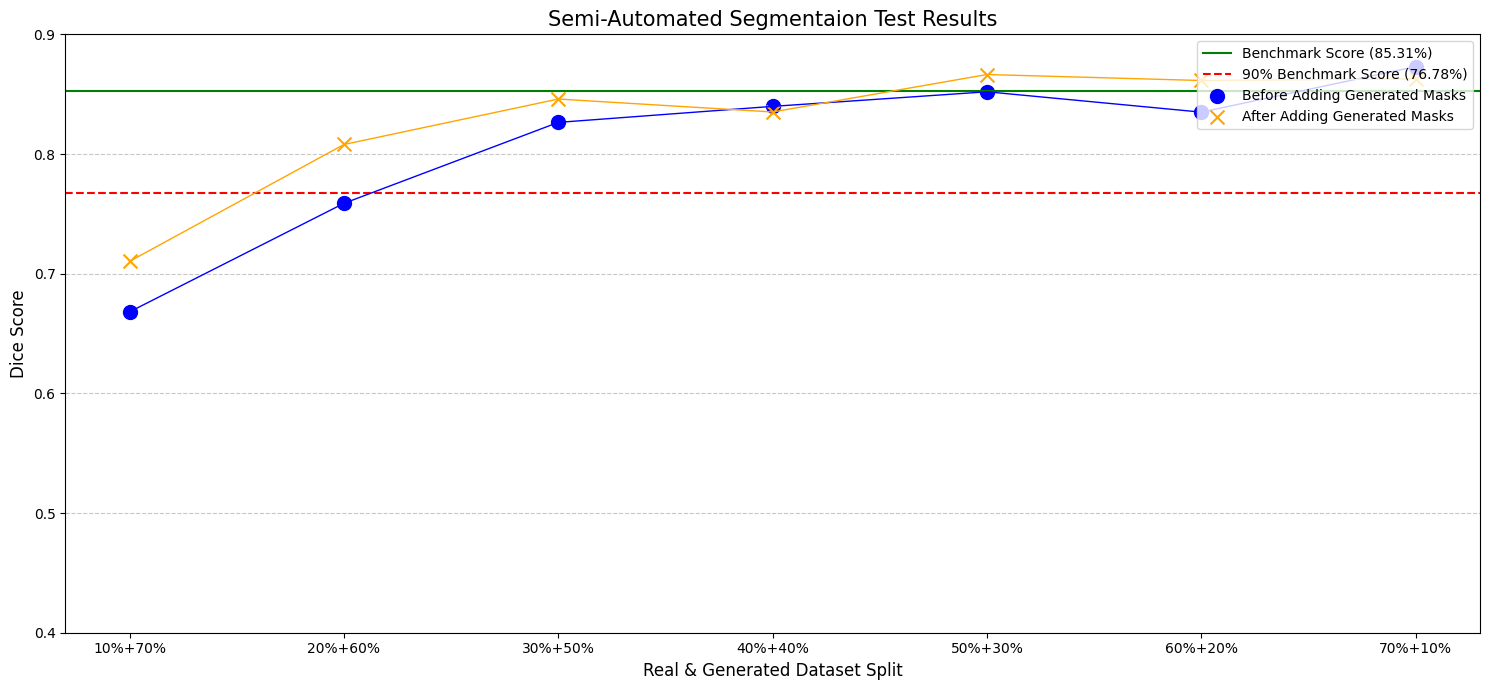

In [23]:
plot_test_results(benchmark_score=benchmark_dice_score,
                  metric_name="Dice",
                  split_list=split_list, 
                  split_label_list=split_label_list,
                  split_score_list_pre=presas_dice_score_list, 
                  split_score_list_post=postsas_dice_score_list, 
                  savefig_name=f"{save_folder}/segformer_test_dice_scores.pdf");

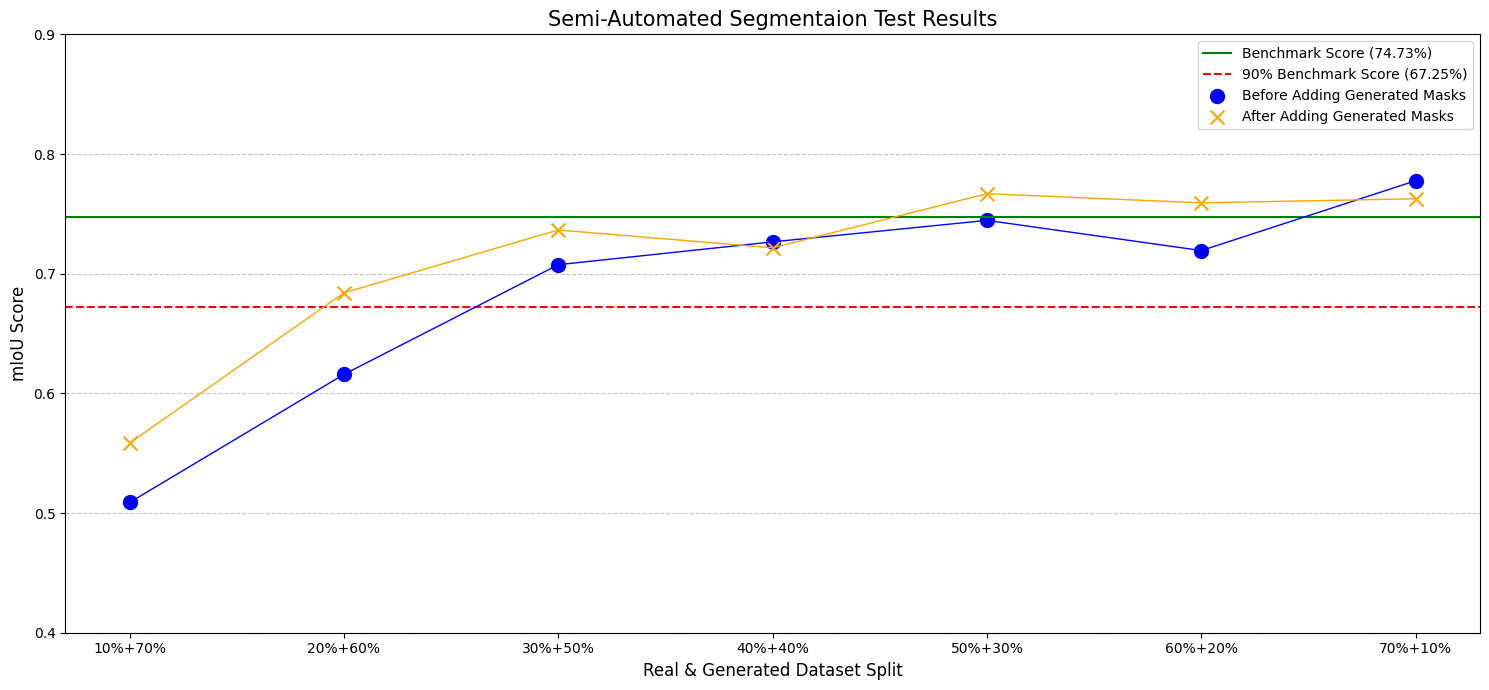

In [24]:
plot_test_results(benchmark_score=benchmark_miou_score,
                  metric_name="mIoU",
                  split_list=split_list, 
                  split_label_list=split_label_list,
                  split_score_list_pre=presas_miou_score_list, 
                  split_score_list_post=postsas_miou_score_list, 
                  savefig_name=f"{save_folder}/segformer_test_miou_scores.pdf");

In [25]:
## Splitwise-Modelwise Mask Comparison
full_dataset = get_dataset(image_size=(384, 384), mask_size=(96, 96))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = random.choice(full_dataset)
results = get_sas_modelwise_results(data=data,
                                    model_dir=f"{seg_semi_auto_path}/models", 
                                    model_name="segformer", 
                                    model_config="b2", 
                                    device=device)

In [26]:
plot_modelwise_comparison(image_data=data, results=results, savefig_name=f"{save_folder}/segformer_modelwise_mask_quality_viz.pdf");

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


### Final Results - UNet

In [27]:
UNET_FINAL_RESULTS_ROOT = f"{ROOT}/final-results-with-unet"
unet_kfold_path = f"{UNET_FINAL_RESULTS_ROOT}/train_kfold"
unet_semi_auto_path = f"{UNET_FINAL_RESULTS_ROOT}/train_semi_auto"
save_folder = "outputs/figures"

unet_model_name = "unet"
unet_model_config = "86"
unet_variant = "size_384x384"
unet_results_fname = "results.json"

In [28]:
## Getting the benchmarks score from kfold training
benchmark_dice_score, benchmark_miou_score = 0.0, 0.0
kfold_results_path = f'{unet_kfold_path}/{unet_model_name}_{unet_model_config}.{unet_variant}.{unet_results_fname}'

with open(f'{kfold_results_path}', 'r') as file:
    kfold_data = json.load(file)

keys = list(kfold_data.keys())
for key in keys:
    benchmark_dice_score += kfold_data[key]["test_dice_score"]
    benchmark_miou_score += kfold_data[key]["test_miou_score"]
    
benchmark_dice_score, benchmark_miou_score = benchmark_dice_score/len(keys), benchmark_miou_score/len(keys)
benchmark_dice_score, benchmark_miou_score

(0.8607764594695148, 0.7583793801419875)

In [29]:
## Loading the semi-automatic data
gen_dataset_path = f'{unet_semi_auto_path}/gen_data'
data = {}
files = os.listdir(gen_dataset_path)
names, gen_files, real_mask_files, dice_score_files = [], [], [], []
for fname in files:
    name = str(fname[-7:-5])
    if name not in names:
        names.append(name)
    if fname[:-8] == "gen_dataset":
        gen_files.append(fname)
    if fname[:-8] == "real_masks":
        real_mask_files.append(fname)
    if fname[:-8] == "dice_scores":
        dice_score_files.append(fname)
    
names.sort() 
gen_files.sort()
real_mask_files.sort()
dice_score_files.sort()

for i in range(len(names)):
    data[names[i]] = {}
    with open(f'{gen_dataset_path}/{gen_files[i]}', 'rb') as file:
        data[names[i]]["gen_dataset"] = pickle.load(file)
    with open(f'{gen_dataset_path}/{real_mask_files[i]}', 'rb') as file:
        data[names[i]]["real_mask"] = pickle.load(file)
    with open(f'{gen_dataset_path}/{dice_score_files[i]}', 'rb') as file:
        data[names[i]]["dice_score"] = pickle.load(file)


In [30]:
keys = list(data.keys())
image_sizes = [len(data[key]["gen_dataset"]) for key in keys]
print(f'Train dataset subset size\t: {keys}')
print(f'Generated dataset sizes\t\t: {image_sizes}')
print(f'Generated dataset image size\t: {data[keys[0]]["gen_dataset"][0][0].shape}')
print(f'Generated dataset mask size\t: {data[keys[0]]["gen_dataset"][0][1].shape}')
print(f'Real dataset mask size\t\t: {data[keys[0]]["real_mask"][0].shape}')

Train dataset subset size	: ['10', '20', '30', '40', '50', '60']
Generated dataset sizes		: [700, 600, 500, 400, 300, 200]
Generated dataset image size	: torch.Size([3, 384, 384])
Generated dataset mask size	: torch.Size([1, 384, 384])
Real dataset mask size		: torch.Size([1, 384, 384])


In [31]:
plot_individual_distribution(data, save_path=f'{save_folder}/unet_distributions');

In [32]:
plot_combined_distribution(data, save_path=f'{save_folder}/unet_distributions');

In [33]:
get_mask_quality_pct(data, save_path=f'{save_folder}/unet_distributions');

In [34]:
### Generating Train & Test Results
with open(f"{unet_semi_auto_path}/{unet_model_name}_{unet_model_config}.{unet_variant}.{unet_results_fname}", "r") as file:
    semi_auto_data = json.load(file)
    
split_list, split_label_list = [], []
presas_dice_score_list, postsas_dice_score_list = [], []
presas_miou_score_list, postsas_miou_score_list = [], []
    
for key in semi_auto_data.keys():
    real_data_pct = int(key[15:])
    split_list.append(real_data_pct)
    split_label_list.append(f'{real_data_pct}%+{80-real_data_pct}%')
    presas_dice_score_list.append(semi_auto_data[key]["presas_test_dice"])
    postsas_dice_score_list.append(semi_auto_data[key]["postsas_test_dice"])
    presas_miou_score_list.append(semi_auto_data[key]["presas_test_miou"])
    postsas_miou_score_list.append(semi_auto_data[key]["postsas_test_miou"])
    print(f'Real Mask {real_data_pct}% + Generated mask {80-real_data_pct}% : \t\tPre-SAS Dice: {semi_auto_data[key]["presas_test_dice"]:.5f}\tPost-SAS: {semi_auto_data[key]["postsas_test_dice"]:.5f} \t\tPre-SAS mIoU: {semi_auto_data[key]["presas_test_miou"]:.5f}\tPost-SAS mIoU: {semi_auto_data[key]["postsas_test_miou"]:.5f}')

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/dewan/Desktop/results//final-results-with-unet/train_semi_auto/unet_86.size_384x384.results.json'

In [ ]:
presas_result_str = ""
for score in presas_dice_score_list:
    presas_result_str += f"{score:.4f}& "
    
postsas_result_str = ""
for score in postsas_dice_score_list:
    postsas_result_str += f"{score:.4f}& "
    
# Dice 
print(presas_result_str)
print(postsas_result_str)

presas_result_str = ""
for score in presas_miou_score_list:
    presas_result_str += f"{score:.4f}& "
    
postsas_result_str = ""
for score in postsas_miou_score_list:
    postsas_result_str += f"{score:.4f}& "
    
# mIoU
print(presas_result_str)
print(postsas_result_str)

In [ ]:
### Mask quality table
keys = sorted(list(data.keys()))
unusables, unreliables, moderates, goods = "", "", "", ""

for idx, key in enumerate(keys):
    sorted_dice_scores = sorted(data[key]["dice_score"], key=lambda x: x[1])
    ids, scores = zip(*sorted_dice_scores)
    scores = [score.cpu().numpy() for score in scores]
    
    unusable = sum(1 for score in scores if score <= 0.0)
    unreliable = sum(1 for score in scores if 0.0 < score < 0.5)
    moderate = sum(1 for score in scores if 0.5 <= score <= 0.8)
    good = sum(1 for score in scores if score > 0.8)
    
    unusables += f"{unusable/len(scores)*100:.2f} & "
    unreliables += f"{unreliable/len(scores)*100:.2f} & "
    moderates += f"{moderate/len(scores)*100:.2f} & "
    goods += f"{good/len(scores)*100:.2f} & "
    
    
print(unusables)
print(unreliables)
print(moderates)
print(goods)

In [ ]:
# plot_test_results(benchmark_score=benchmark_dice_score,
#                   metric_name="Dice",
#                   split_list=split_list, 
#                   split_label_list=split_label_list,
#                   split_score_list_pre=presas_dice_score_list, 
#                   split_score_list_post=postsas_dice_score_list, 
#                   savefig_name=f"{save_folder}/unet_test_dice_scores.pdf");

In [ ]:
# plot_test_results(benchmark_score=benchmark_miou_score,
#                   metric_name="mIoU",
#                   split_list=split_list, 
#                   split_label_list=split_label_list,
#                   split_score_list_pre=presas_miou_score_list, 
#                   split_score_list_post=postsas_miou_score_list, 
#                   savefig_name=f"{save_folder}/unet_test_miou_scores.pdf");

In [ ]:
# ## Splitwise-Modelwise Mask Comparison
# full_dataset = get_dataset(image_size=(256, 256), mask_size=(256, 256))
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# data = random.choice(full_dataset)

# results = get_sas_modelwise_results(data=data,
#                                     model_dir=f"{unet_semi_auto_path}/models", 
#                                     model_name="unet", 
#                                     model_config="114", 
#                                     device=device)

In [ ]:
# plot_modelwise_comparison(image_data=data, results=results, savefig_name=f"{save_folder}/unet_modelwise_mask_quality_viz.pdf")